##### imports

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
data = yf.download('^GSPC', start='2010-01-01', end='2025-01-01')

data = data.reset_index()

data['Date'] = pd.to_datetime(data['Date'])

data = data.sort_values('Date').reset_index(drop=True)


if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)
    
data.head().T

C:\Users\rossg\AppData\Local\Temp\ipykernel_28556\2962204372.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('^GSPC', start='2010-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


,0,1,2,3,4
Price,,,,,
Date,2010-01-04 00:00:00,2010-01-05 00:00:00,2010-01-06 00:00:00,2010-01-07 00:00:00,2010-01-08 00:00:00
Close,1132.98999,1136.52002,1137.140015,1141.689941,1144.97998
High,1133.869995,1136.630005,1139.189941,1142.459961,1145.390015
Low,1116.560059,1129.660034,1133.949951,1131.319946,1136.219971
Open,1116.560059,1132.660034,1135.709961,1136.27002,1140.52002
Volume,3991400000,2491020000,4972660000,5270680000,4389590000


##### Previous feature engineering

In [5]:
data['Pct_Change'] = data['Close'].pct_change()
data['MA_3'] = data['Close'].rolling(window=3).mean()
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['Volatility'] = data['Close'].rolling(window=10).std()
data['Direction'] = np.where(data['Close'].shift(-1) > data['Close'], 'Up', 'Down') 

## Section A

In [7]:
# checking for missing values

cnt_missing = data.isna().sum()

missing_perc = (cnt_missing / len(data)) * 100

#quick table of missing data

tbl_4_missing = pd.DataFrame({
    'Count of Missing': cnt_missing,
    'Percent Missing':missing_perc.round()
}).sort_values('Count of Missing')

tbl_4_missing

,Count of Missing,Percent Missing
Price,,
Date,0,0.0
Close,0,0.0
High,0,0.0
Low,0,0.0
Open,0,0.0
Volume,0,0.0
Direction,0,0.0
Pct_Change,1,0.0
MA_3,2,0.0


The table was created as an audit for missing values and shows that all NaNs exclusively occur in features created for rolling window or percent change calculations. These missing values are expected in financial time-series data when pre-processing and will be removed after the creation of all engineered features.

In [9]:
row_miss_vals = data[data.isna().any(axis=1)]

row_miss_vals.head(10)

Price,Date,Close,High,Low,Open,Volume,Pct_Change,MA_3,MA_5,MA_10,Volatility,Direction
0,2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000,NaN,NaN,NaN,NaN,NaN,Up
1,2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000,0.003116,NaN,NaN,NaN,NaN,Up
2,2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000,0.000546,1135.550008,NaN,NaN,NaN,Up
3,2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000,0.004001,1138.449992,NaN,NaN,NaN,Up
4,2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000,0.002882,1141.269979,1138.663989,NaN,NaN,Up
5,2010-01-11,1146.979980,1149.739990,1142.020020,1145.959961,4255780000,0.001747,1144.549967,1141.461987,NaN,NaN,Down
6,2010-01-12,1136.219971,1143.810059,1131.770020,1143.810059,4716160000,-0.009381,1142.726644,1141.401978,NaN,NaN,Up
7,2010-01-13,1145.680054,1148.400024,1133.180054,1137.310059,4170360000,0.008326,1142.960002,1143.109985,NaN,NaN,Up
8,2010-01-14,1148.459961,1150.410034,1143.800049,1145.680054,3915200000,0.002426,1143.453328,1144.463989,NaN,NaN,Down


Justification for missing values:

- Pct_Change() creates a Nan since there is no previous day price
- Rolling Windows (3,5,10 day) - these require prior observations which causes NaN's at the beginning of the data set
- Volatility: shows several initial NaNs because a 10 day rolling standard deviation can't compute until 10 days of returns are available.

In [11]:
split = int(len(data)*0.8)

train_set = data.iloc[:split].copy()

test_set = data.iloc[split:].copy()


print(train_set['Date'].min())
print(train_set['Date'].max())


print(test_set['Date'].min())
print(test_set['Date'].max())

print("Training Rows:", len(train_set))
print("Testing Rows:", len(test_set))

2010-01-04 00:00:00
2021-12-29 00:00:00
2021-12-30 00:00:00
2024-12-31 00:00:00
Training Rows: 3019
Testing Rows: 755


The training set goes from 1/4/2010 to 12/29/2021 with 3019 rows (80 split).

The test set goes from 12/30/2021 to 12/31/2024 with 755 rows (20 split).

The date is checked to confirm the data is in chronological order with the training and test sets. The Training set starts earlier and ends earlier and the test set begins immediately after the training set ends. This confirms there are no jumps or overlap. This confirms the model will only be tested on future data, that hasn't yet been seen, which prevents data leakage.

## Section B

In [14]:
#calculating daily return

data['return_1d'] = data['Close'].pct_change()

#creation of different lags for short term patterns

lags = [1,2,3,5,7]

#we need to apply these lags now so we get these features

for lag in lags:
    col_name = f'return_lag_{lag}d'

    data[col_name] = data['return_1d'].shift(lag)

print(data.head(10))

Price       Date        Close         High          Low         Open  \
0     2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059   
1     2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034   
2     2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961   
3     2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020   
4     2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020   
5     2010-01-11  1146.979980  1149.739990  1142.020020  1145.959961   
6     2010-01-12  1136.219971  1143.810059  1131.770020  1143.810059   
7     2010-01-13  1145.680054  1148.400024  1133.180054  1137.310059   
8     2010-01-14  1148.459961  1150.410034  1143.800049  1145.680054   
9     2010-01-15  1136.030029  1147.770020  1131.390015  1147.719971   

Price      Volume  Pct_Change         MA_3         MA_5        MA_10  \
0      3991400000         NaN          NaN          NaN          NaN   
1      2491020000    0.003116          NaN          NaN        

The percent change in closing price is used to observe day to day market changes. For this, lags were engineered at 1,2,3,5, and 7 days to capture short term patterns and market reversals. The lag period was selected because in financial analysis these are the commonly used to capture immediate price movements, and then multi-day, and then weekly flutuation.

In [16]:
#calculatiion of rolling volatility

#we will do this based on the standard deviation of the 10 day daily returns

data['rolling_vol_10d'] = data['return_1d'].rolling(window = 10).std()

#could compute extra not sure if we need it yet...

data[['Date', 'return_1d', 'rolling_vol_10d']].head(20)

Price,Date,return_1d,rolling_vol_10d
0,2010-01-04,NaN,NaN
1,2010-01-05,0.003116,NaN
2,2010-01-06,0.000546,NaN
3,2010-01-07,0.004001,NaN
4,2010-01-08,0.002882,NaN
5,2010-01-11,0.001747,NaN
6,2010-01-12,-0.009381,NaN
7,2010-01-13,0.008326,NaN
8,2010-01-14,0.002426,NaN
9,2010-01-15,-0.010823,NaN


The 10 day rolling volatility was calculated using the standard deviation of the past 10 day daily returns. This window captures short term market risks.  Using 10 days helps give a more gradual change instead of showing isolated fluctuations or noise. The first 9 rows are expected to have missing values because a full 10 days is needed to be able to do the calculation.

In [18]:
#this is a 10day moving average of daily returns, might be helpful for PCA and supervised model

data['ma_return_10d'] = data['return_1d'].rolling(window=10).mean()

data[['Date', 'Close', 'return_1d', 'ma_return_10d']].head(15)

Price,Date,Close,return_1d,ma_return_10d
0,2010-01-04,1132.989990,NaN,NaN
1,2010-01-05,1136.520020,0.003116,NaN
2,2010-01-06,1137.140015,0.000546,NaN
3,2010-01-07,1141.689941,0.004001,NaN
4,2010-01-08,1144.979980,0.002882,NaN
5,2010-01-11,1146.979980,0.001747,NaN
6,2010-01-12,1136.219971,-0.009381,NaN
7,2010-01-13,1145.680054,0.008326,NaN
8,2010-01-14,1148.459961,0.002426,NaN
9,2010-01-15,1136.030029,-0.010823,NaN


The 10 day moving average of daily returns will tell us if the market has trendede up or down over the past 10 days. This will help remove noise and help capture actual patterns and identify short term trend behaviors.

In [20]:
# creation of a sharpe-like Ratio

data['sharpe_like_10d'] = data['return_1d'] / data['rolling_vol_10d']

# double checking the ratio
data[['Date', 'return_1d', 'rolling_vol_10d', 'sharpe_like_10d']].head(15)

Price,Date,return_1d,rolling_vol_10d,sharpe_like_10d
0,2010-01-04,NaN,NaN,NaN
1,2010-01-05,0.003116,NaN,NaN
2,2010-01-06,0.000546,NaN,NaN
3,2010-01-07,0.004001,NaN,NaN
4,2010-01-08,0.002882,NaN,NaN
5,2010-01-11,0.001747,NaN,NaN
6,2010-01-12,-0.009381,NaN,NaN
7,2010-01-13,0.008326,NaN,NaN
8,2010-01-14,0.002426,NaN,NaN
9,2010-01-15,-0.010823,NaN,NaN


The Sharpe-like ratio feature is engineered by dividing daily returns by the 10 day rolling volatility. It helps to show whether the current days return is strong or weak compared to recent market movement. High values mean low risk upward market movement while low values indicate high volatility with low returns.

In [22]:
clean_data = data.dropna()

print(len(data)) # data before dropping NA's
print(len(clean_data)) # data after dropping NA's

data[['Date', 'return_1d', 'rolling_vol_10d', 'sharpe_like_10d']].head(15)

3774
3764


Price,Date,return_1d,rolling_vol_10d,sharpe_like_10d
0,2010-01-04,NaN,NaN,NaN
1,2010-01-05,0.003116,NaN,NaN
2,2010-01-06,0.000546,NaN,NaN
3,2010-01-07,0.004001,NaN,NaN
4,2010-01-08,0.002882,NaN,NaN
5,2010-01-11,0.001747,NaN,NaN
6,2010-01-12,-0.009381,NaN,NaN
7,2010-01-13,0.008326,NaN,NaN
8,2010-01-14,0.002426,NaN,NaN
9,2010-01-15,-0.010823,NaN,NaN


The rows containing missing values are removed after creation of engineered features. These were expected to be NaN due to the nature and lagged features. Dropping them is important for the model to ensure we have complete data for it to use.

### Feature Selection

In [25]:
clean_data = data.dropna().copy()

#convert target to binary (Up = 1, Down = 0)
clean_data['Direction'] = clean_data['Direction'].map({'Up': 1, 'Down': 0}).astype(int)

#remove non-modeling columns
clean_data = clean_data.drop(columns=['Date'], errors='ignore')

#remove low-variance
low_variance = clean_data.var()[clean_data.var() < 1e-5].index
clean_data = clean_data.drop(columns=low_variance)

corr = clean_data.corr()

In [26]:
correlation_matrix = clean_data.corr(numeric_only=True)
high_corr_pairs = correlation_matrix[(correlation_matrix > 0.9) & (correlation_matrix != 1.0)]

print("High correlations:\n", high_corr_pairs)

feature_std = clean_data.std(numeric_only=True)
low_variance_cols = feature_std[feature_std < 1e-6].index.tolist()

print("Low variance features:", low_variance_cols)

clean_data = clean_data.drop(columns=low_variance_cols)

High correlations:
 Price               Close      High       Low      Open  Volume  Pct_Change  \
Price                                                                         
Close                 NaN  0.999889  0.999907  0.999799     NaN         NaN   
High             0.999889       NaN  0.999847  0.999923     NaN         NaN   
Low              0.999907  0.999847       NaN  0.999884     NaN         NaN   
Open             0.999799  0.999923  0.999884       NaN     NaN         NaN   
Volume                NaN       NaN       NaN       NaN     NaN         NaN   
Pct_Change            NaN       NaN       NaN       NaN     NaN         NaN   
MA_3             0.999838  0.999909  0.999848  0.999928     NaN         NaN   
MA_5             0.999656  0.999794  0.999652  0.999803     NaN         NaN   
MA_10            0.999233  0.999466  0.999156  0.999410     NaN         NaN   
Volatility            NaN       NaN       NaN       NaN     NaN         NaN   
Direction             NaN       

### Unsupervised Feature Engineering

In [28]:
y = clean_data['Direction']
X = clean_data.drop(columns=['Direction', 'Date'], errors='ignore')

split_index = int(len(X) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Number of PCA components: 9
Explained variance ratio: [0.39969652 0.1571895  0.1169881  0.06989059 0.06246396 0.05190864
 0.04595189 0.04279145 0.03116124]


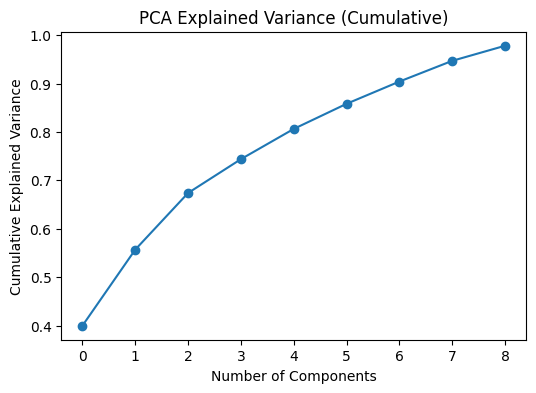

In [29]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Number of PCA components:", pca.n_components_)
print("Explained variance ratio:", pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance (Cumulative)")
plt.show()

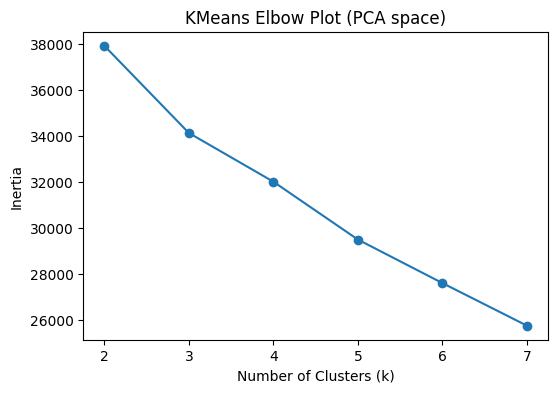

In [30]:
inertia = []
K = range(2, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_train_pca)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("KMeans Elbow Plot (PCA space)")
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
train_clusters = kmeans.fit_predict(X_train_pca)
test_clusters = kmeans.predict(X_test_pca)

## Section C

### Supervised Engineering

In [38]:
# Modeling Imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

In [40]:
# Logistic Regression
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train_scaled, y_train)
log_preds = log_model.predict(X_test_scaled)

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

In [42]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n===== {name} =====")
    print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
    print("Precision:", round(precision_score(y_true, y_pred), 4))
    print("Recall   :", round(recall_score(y_true, y_pred), 4))
    print("F1 Score :", round(f1_score(y_true, y_pred), 4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

evaluate_model("Logistic Regression", y_test, log_preds)
evaluate_model("Random Forest", y_test, rf_preds)


===== Logistic Regression =====
Accuracy : 0.5232
Precision: 0.5194
Recall   : 0.9664
F1 Score : 0.6757
Confusion Matrix:
 [[ 20 346]
 [ 13 374]]

===== Random Forest =====
Accuracy : 0.5007
Precision: 0.5122
Recall   : 0.5943
F1 Score : 0.5502
Confusion Matrix:
 [[147 219]
 [157 230]]


## Section D - Initial Model Assumptions and Overfitting Checks

In [61]:
#RS
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

### Logistic Regression – ROC Curve and AUC

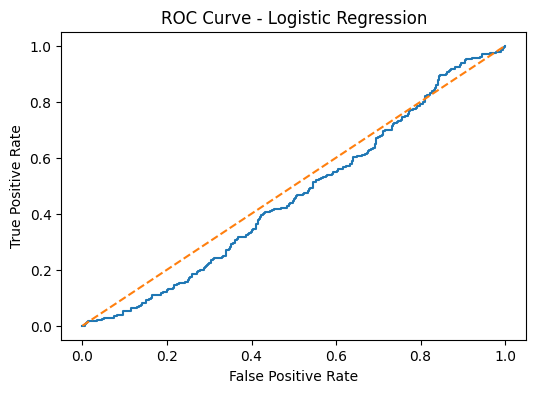

AUC Score: 0.4640784513068158


In [64]:
#RS
log_probs = log_model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, log_probs)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.show()

print("AUC Score:", roc_auc_score(y_test, log_probs))

The ROC curve stays close to the diagonal line, and the AUC score of 0.464 indicates the model performs worse than random guessing when predicting daily S&P 500 direction.

### Logistic Regression – Coefficients

In [67]:
#RS
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_model.coef_[0]
})
coef_df.sort_values("Coefficient", key=abs, ascending=False).head(10)


,Feature,Coefficient
8,MA_10,0.391313
1,High,-0.223343
3,Open,-0.205079
2,Low,0.159201
0,Close,-0.158002
7,MA_5,0.072385
16,rolling_vol_10d,0.070827
9,Volatility,-0.053202
10,return_1d,-0.048647
5,Pct_Change,-0.048647


The Logistic Regression coefficients are small and mixed in direction. This suggests that no individual feature has strong predictive power for next-day movements, which is consistent with the difficulty of forecasting daily market direction.

### Random Forest – Feature Importance

In [52]:
#RS
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values("Importance", ascending=False)

feat_imp.head(10)

,Feature,Importance
14,return_lag_5d,0.070912
13,return_lag_3d,0.070172
15,return_lag_7d,0.069948
12,return_lag_2d,0.068748
4,Volume,0.068551
11,return_lag_1d,0.068517
16,rolling_vol_10d,0.065683
9,Volatility,0.063827
17,sharpe_like_10d,0.060312
10,return_1d,0.056876


The Random Forest places highest importance on short-term lagged returns (lags 3–7 days), implying that very recent price changes contain the strongest signals, though the overall importance values are modest and do not translate into high predictive accuracy.

### Overfitting Check - Train vs Test Accuracy

In [70]:
#RS
print("Logistic Regression Training Accuracy:", log_model.score(X_train_scaled, y_train))
print("Logistic Regression Testing Accuracy:", log_model.score(X_test_scaled, y_test))

print("Random Forest Training Accuracy:", rf_model.score(X_train, y_train))
print("Random Forest Testing Accuracy:", rf_model.score(X_test, y_test))

Logistic Regression Training Accuracy: 0.5572899368980405
Logistic Regression Testing Accuracy: 0.5232403718459495
Random Forest Training Accuracy: 1.0
Random Forest Testing Accuracy: 0.50066401062417


Logistic Regression shows a small train test gap (0.56 vs 0.52). This means there is no major overfitting. Random Forest perfectly fits the training data (1.0 training accuracy) but performs poorly on the test set (0.5), which indicates substantial overfitting.

### Cross-Validation Score

In [58]:
#RS
from sklearn.model_selection import cross_val_score

log_cv = cross_val_score(log_model, X_train_scaled, y_train, cv=5)
rf_cv = cross_val_score(rf_model, X_train, y_train, cv=5)

print("Logistic Regression CV:", log_cv.mean())
print("Random Forest CV:", rf_cv.mean())

Logistic Regression CV: 0.5403530520156692
Random Forest CV: 0.5127766483198625


Cross validation averages confirm that both models generalize poorly and struggle to find stable predictive patterns in daily market data.

### Confusion Matrix Heatmap

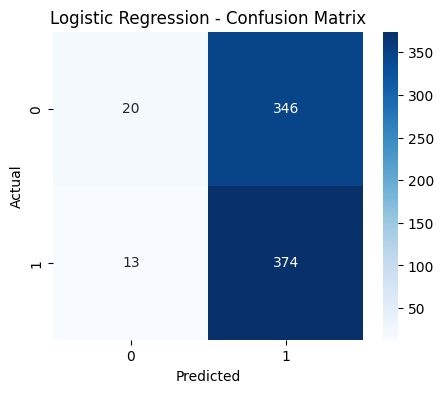

In [73]:
#RS
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, log_preds), annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The matrix shows the model is heavily based toward predicting Up. It correctly identifies most upward days but is missing almost all downward days.

### Baseline Accuracy

In [76]:
#RS
baseline = y_test.value_counts(normalize=True).max()
print("Baseline Accuracy (Majority Class):", round(baseline, 4))

Baseline Accuracy (Majority Class): 0.5139


The baseline accuracy is 0.514, very close to both model accuracies. The models are currently barely outperform simply predicting the majority class.

### Probability Distribution Plot

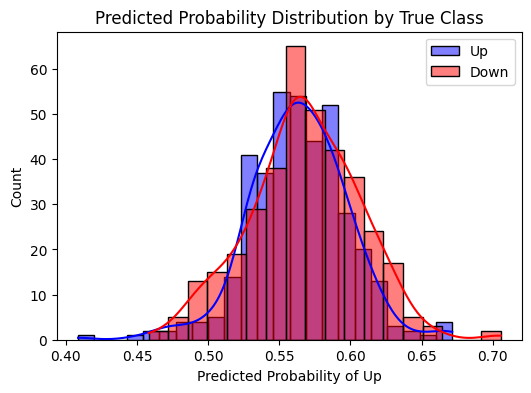

In [79]:
#RS
plt.figure(figsize=(6,4))
sns.histplot(log_probs[y_test==1], kde=True, color="blue", alpha=0.5, label="Up")
sns.histplot(log_probs[y_test==0], kde=True, color="red", alpha=0.5, label="Down")
plt.title("Predicted Probability Distribution by True Class")
plt.xlabel("Predicted Probability of Up")
plt.legend()
plt.show()

The predicted probability distributions for Up and Down days overlap almost completely, indicating the model struggles to produce meaningfully different probability estimates for the two outcomes.

### Class Imbalance Check

In [82]:
#RS
print("Class Distribution in Test Set:")
print(y_test.value_counts(normalize=True))

Class Distribution in Test Set:
Direction
1    0.513944
0    0.486056
Name: proportion, dtype: float64


The test set is roughly balanced (51% Up, 49% Down), confirming that model performance issues are not due to class imbalance but rather lack of predictive signal.

As we move on to the next part of the project and tune the models, we hope to get better predictive power. Additionally, we may add additional models like XGBoost to achieve better accuracy.